# Forecasting Stock Perfomance with Prophet

<p><img src="https://picsum.photos/1200/200/?image=357" class="img-fluid" alt="Responsive image" /></p>

In this post we will be using [Prophet](https://facebook.github.io/prophet/) to forecast time series data.  The data we will be using is historical daily SA&P 500 adjusted close price.  We will first create a 3 year forecast usind ytd data and then simulate historical monthly forecasts dating back to 1980.   Finally we will create various trading strategies to attempt to beat the tried and true method of buying and holding.

Sections:
* [Imports](#Imports)
* [Data Preparation](#Data-Preparation)
* [Prophet](#Prophet)
* [Simulating Forecasts](#Simulating-Forecasts)
* [Trading Algorithms](#Trading-Algorithms)
* [Summary](#Summary)

## Imports

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
from functools import reduce

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
 
plt.style.use('seaborn-deep')
pd.options.display.float_format = "{:,.2f}".format

For this project we will be importing the standard libraries for data anaysis with Python.  We will also import Prophet and reduce from functools which will be used to help simulate our Forecasts.

## The Data

In [2]:
stock_price =  pd.read_csv('^GSPC.csv',parse_dates=['Date'])

In [3]:
stock_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9885 entries, 0 to 9884
Data columns (total 7 columns):
Date         9885 non-null datetime64[ns]
Open         9885 non-null float64
High         9885 non-null float64
Low          9885 non-null float64
Close        9885 non-null float64
Adj Close    9885 non-null float64
Volume       9885 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 540.7 KB


In [4]:
stock_price.describe()

,Open,High,Low,Close,Adj Close,Volume
count,"9,885.00","9,885.00","9,885.00","9,885.00","9,885.00","9,885.00"
mean,958.64,964.26,952.65,958.86,958.86,"1,628,930,637.33"
std,696.19,699.39,692.67,696.24,696.24,"1,765,031,087.55"
min,98.22,99.58,94.23,98.22,98.22,"14,990,000.00"
25%,326.24,328.00,322.98,326.35,326.35,"169,010,000.00"
50%,955.40,965.38,949.45,955.41,955.41,"805,900,000.00"
75%,"1,347.74","1,355.87","1,336.36","1,347.74","1,347.74","3,150,330,000.00"
max,"2,936.76","2,940.91","2,927.11","2,930.75","2,930.75","11,456,230,000.00"


The data we are using is the historical S&P500 prices dating back to 1980.  You can find the data [here](https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC).

## Data Preparation

In [5]:
stock_price = stock_price[['Date','Adj Close']]

In [6]:
stock_price.columns = ['ds', 'y']
stock_price.head(10)

,ds,y
0,1980-01-02,105.76
1,1980-01-03,105.22
2,1980-01-04,106.52
3,1980-01-07,106.81
4,1980-01-08,108.95
5,1980-01-09,109.05
6,1980-01-10,109.89
7,1980-01-11,109.92
8,1980-01-14,110.38
9,1980-01-15,111.14


For prophet to work, we need to change the names of the 'Date' and 'Adj Close' columns to 'ds' and 'y'.  The term 'y' is typically used for the target column (what you are trying to predict) in most machine learning projects.

## Prophet

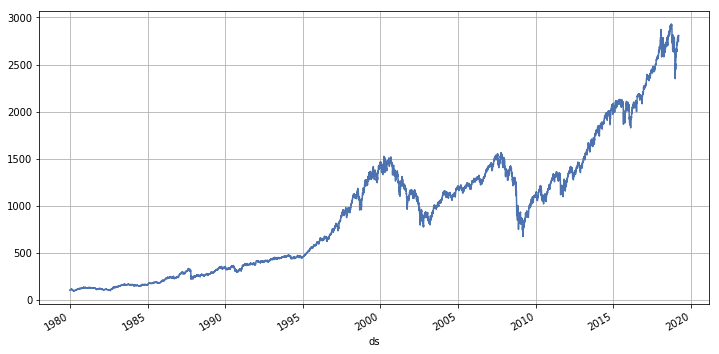

In [7]:
stock_price.set_index('ds').y.plot(figsize=(12,6), grid=True);

Before we use Prophet to create a forecast let's visualize our data.  It's always a good idea to create a few visualitions to gain a better understanding of the data you are working with.

In [8]:
model = Prophet()
model.fit(stock_price)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


To activate the Prophet Model we simply call `Prophet()` and assign it to a variabl called `model`. Next fit our stock data to the model by calling the `fit` method.

In [9]:
future = model.make_future_dataframe(1095, freq='d')

future_boolean = future['ds'].map(lambda x : True if x.weekday() in range(0, 5) else False)
future = future[future_boolean] 

future.tail()

,ds
10973,2022-03-07
10974,2022-03-08
10975,2022-03-09
10976,2022-03-10
10977,2022-03-11


To create a forecast with our model we need to create some futue dates.  Prophet provides us with a helper function called `make_future_dataframe`.  We pass in the number of future periods and frequency.  Above we created a forecast for the next 1095 days or 3 years.

Since stocks can only be traded on weekdays we need to remove the weekends from our forecast dataframe.  To do so we create a boolean expression where if a day does not equal 0 - 4 then return False.  "0 = Monday, 6=Saturday, etc.."

We then pass the boolean expression to our dataframe with returns only True values.  We now have a forecast dataframe comprised of the next 3 years of weekdays.

In [10]:
forecast = model.predict(future)

In [11]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
10661,2022-03-07,"3,398.27","3,043.92","3,765.33","3,050.21","3,757.76",0.46,0.46,0.46,0.90,0.90,0.90,-0.44,-0.44,-0.44,0.00,0.00,0.00,"3,398.73"
10662,2022-03-08,"3,398.82","3,035.27","3,784.78","3,049.62","3,758.73",1.09,1.09,1.09,1.40,1.40,1.40,-0.30,-0.30,-0.30,0.00,0.00,0.00,"3,399.92"
10663,2022-03-09,"3,399.38","3,044.68","3,769.69","3,049.04","3,759.69",1.25,1.25,1.25,1.37,1.37,1.37,-0.12,-0.12,-0.12,0.00,0.00,0.00,"3,400.63"
10664,2022-03-10,"3,399.93","3,034.44","3,796.22","3,048.49","3,760.65",1.43,1.43,1.43,1.32,1.32,1.32,0.10,0.10,0.10,0.00,0.00,0.00,"3,401.36"
10665,2022-03-11,"3,400.49","3,040.25","3,798.08","3,047.96","3,761.62",1.48,1.48,1.48,1.11,1.11,1.11,0.37,0.37,0.37,0.00,0.00,0.00,"3,401.97"


To create the forecast we call `predict` from our `model` and pass in the `future` dataframe we created earlier.  We return the results in a new dataframe called `forecast`.  

When we inspect the `forecast` dataframe we see a bunch of new terms.  The one we are most interested in is `yhat` which is our forecasted value.

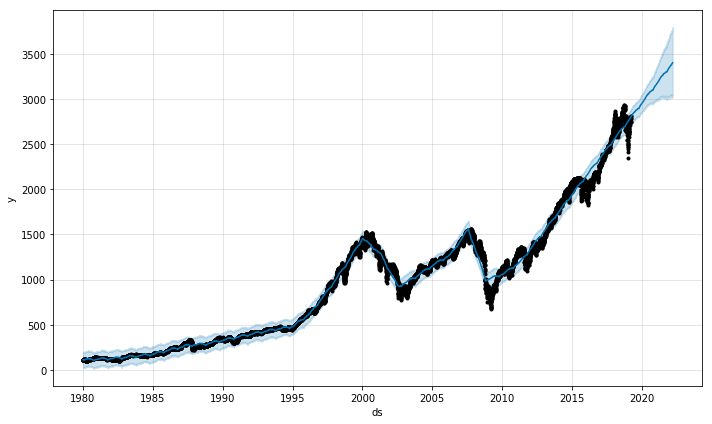

In [12]:
model.plot(forecast);

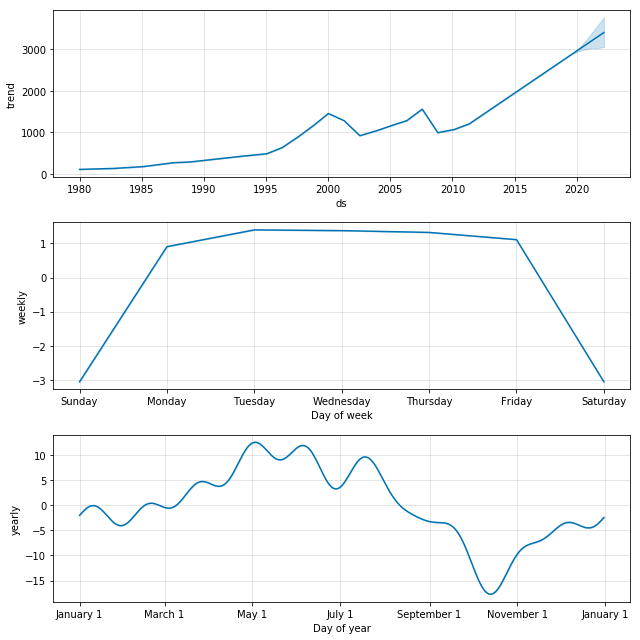

In [13]:
model.plot_components(forecast);

All the new fields appear a bit daunting but fortunately Prophet comes with two handy visualization helpers, `plot` and `plot_components`.  The `plot` functions creates a graph of our actuals and forecast and `plot_components` provides us a graph of our trend and seasonality.

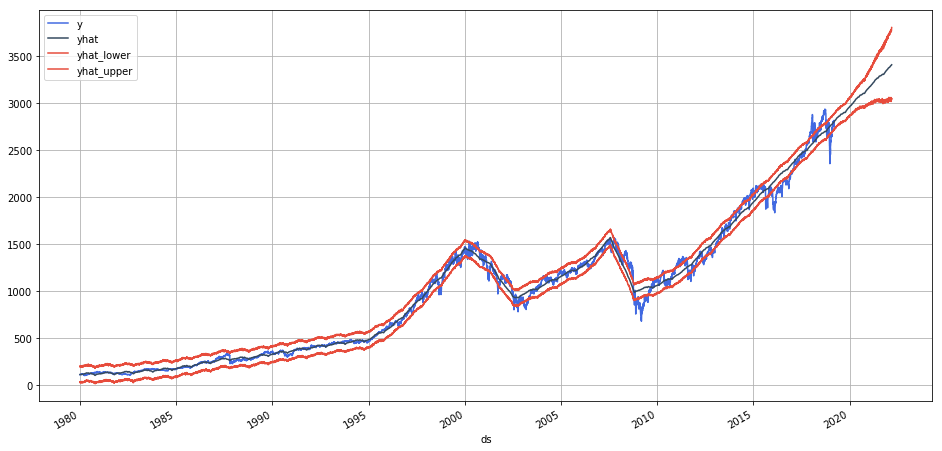

In [14]:
stock_price_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
df = pd.merge(stock_price, stock_price_forecast, on='ds', how='right')
df.set_index('ds').plot(figsize=(16,8), color=['royalblue', "#34495e", "#e74c3c", "#e74c3c"], grid=True);

The visualization helpers are just using the data in our `forecast` dataframe.  We can actually recreate the same graphs.  Above I recreated the `plot` graph.

## Simulating Forecasts

While the 3 year forecast we created above is pretty cool we don't want to make any trading decisions on it without backtesting the performance and a trading strategy.  

In this section we will simulate as if Prophet existed back in 1980 and we used it to creat a monthly forecast through 2019.  We will then use this data in the following section to simulate how various trading strategies did vs if we just bought and held on to the stock.

In [15]:
stock_price['dayname'] = stock_price['ds'].dt.day_name()
stock_price['month'] = stock_price['ds'].dt.month
stock_price['year'] = stock_price['ds'].dt.year
stock_price['month/year'] = stock_price['month'].map(str) + '/' + stock_price['year'].map(str) 

stock_price = pd.merge(stock_price, 
                       stock_price['month/year'].drop_duplicates().reset_index(drop=True).reset_index(),
                       on='month/year',
                       how='left')

stock_price = stock_price.rename(columns={'index':'month/year_index'})

In [16]:
stock_price.tail()

,ds,y,dayname,month,year,month/year,month/year_index
9880,2019-03-08,"2,743.07",Friday,3,2019,3/2019,470
9881,2019-03-11,"2,783.30",Monday,3,2019,3/2019,470
9882,2019-03-12,"2,791.52",Tuesday,3,2019,3/2019,470
9883,2019-03-13,"2,810.92",Wednesday,3,2019,3/2019,470
9884,2019-03-14,"2,808.48",Thursday,3,2019,3/2019,470


Before we simulate the monthly forecasts we need to add some columns to our `stock_price` dataframe we created in the beginning of this project to make it a bit easier to work with.  We add month, year, month/year, and month/year_index. 

In [ ]:
loop_list = stock_price['month/year'].unique().tolist()
max_num = len(loop_list) - 1
forecast_frames = []

for num, item in enumerate(loop_list):

    if  num == max_num:
        pass
    else:
        df = stock_price.set_index('ds')[
             stock_price[stock_price['month/year'] == loop_list[0]]['ds'].min():\
             stock_price[stock_price['month/year'] == item]['ds'].max()]
        
        df = df.reset_index()[['ds', 'y']]
        
        model = Prophet()
        model.fit(df)
        
        future = stock_price[stock_price['month/year_index'] == (num + 1)][['ds']]

        forecast = model.predict(future)
        forecast_frames.append(forecast)

In [ ]:
stock_price_forecast = reduce(lambda top, bottom: pd.concat([top, bottom], sort=False), forecast_frames)
stock_price_forecast = stock_price_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
stock_price_forecast.to_csv('stock_price_forecast.csv', index=False)

Above is a lot but essentially we are looping through each unique `month/year` in the stock_price and fitting the `Prophet` model with the stock data available to that period and then forecasting out one month ahead.  We continue to do this until we hit the last unique `month/year`.  Finally we combine these forecasts into a single dataframe called `stock_price_forecast`.  I save the results as it take a while to run and in case I need to reset I can pull the csv file instead of running the model again.

In [17]:
stock_price_forecast = pd.read_csv('stock_price_forecast.csv', parse_dates=['ds'])

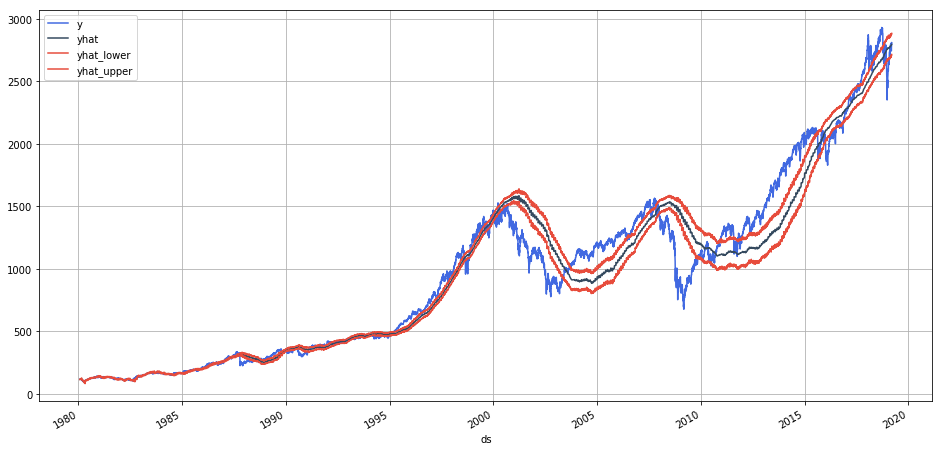

In [18]:
df = pd.merge(stock_price[['ds','y', 'month/year_index']], stock_price_forecast, on='ds')
df['Percent Change'] = df['y'].pct_change()
df.set_index('ds')[['y', 'yhat', 'yhat_lower', 'yhat_upper']].plot(figsize=(16,8), color=['royalblue', "#34495e", "#e74c3c", "#e74c3c"], grid=True)

In [19]:
df.head()

,ds,y,month/year_index,yhat,yhat_lower,yhat_upper,Percent Change
0,1980-02-01,115.12,1,115.23,114.60,115.85,nan
1,1980-02-04,114.37,1,115.74,115.12,116.46,-0.01
2,1980-02-05,114.66,1,116.05,115.38,116.75,0.00
3,1980-02-06,115.72,1,116.79,116.15,117.50,0.01
4,1980-02-07,116.28,1,116.50,115.79,117.23,0.00


Finally we combine our forecast with the actual prices and create a `Percent Change` column which will be used in our Trading Algorithms below.  Lastly, I plot the forecasts with the actuals to see how well it did.  As you can see there is a bit of a delay.  It kind of behaves a lot like a moving average would.

## Trading Algorithms

In [20]:
df['Hold'] = (df['Percent Change'] + 1).cumprod()
df['Prophet'] = ((df['yhat'].shift(-1) > df['yhat']).shift(1) * (df['Percent Change']) + 1).cumprod()
df['Prophet Thresh']  = ((df['y'] > df['yhat_lower']).shift(1)* (df['Percent Change']) + 1).cumprod()
df['Seasonality'] = ((~df['ds'].dt.month.isin([8,9])).shift(1) * (df['Percent Change']) + 1).cumprod()

Above we create four initial trading algorithms:
* **Hold**: Our bench mark.  This is a buy and hold strategy. Meaning we buy the stock and hold on to it until the end time period.
* **Prophet**: This strategy is to sell when our forecast indicates a down trend and buy back in when it iindicates an upward trend
* **Prophet Thresh**: This strategy is to only sell when the stock price fall below our yhat_lower boundary.
* **Seasonality**:  This strategy is to exit the market in August and re-enter in Ocober. This was based on the seasonality chart from above.

Hold = 24,396
Prophet = 13,366
Prophet Thresh = 17,087
Seasonality = 30,861


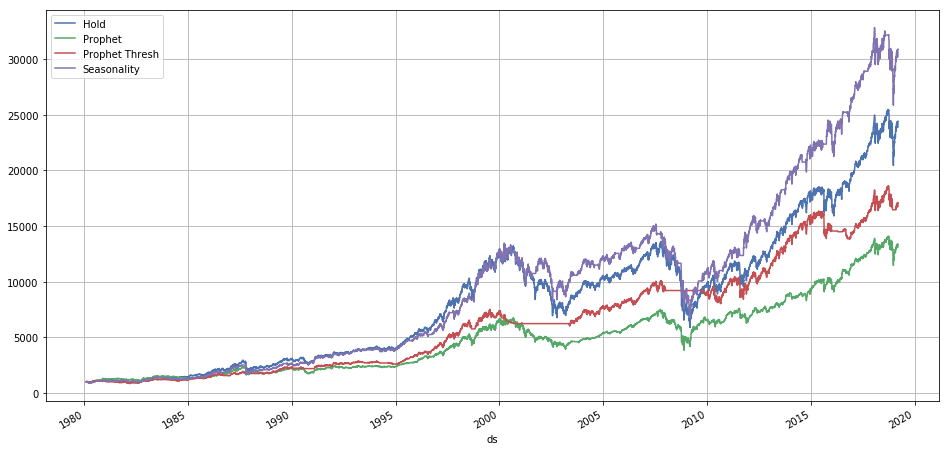

In [21]:
(df.dropna().set_index('ds')[['Hold', 'Prophet', 'Prophet Thresh','Seasonality']] * 1000).plot(figsize=(16,8), grid=True)

print(f"Hold = {df['Hold'].iloc[-1]*1000:,.0f}")
print(f"Prophet = {df['Prophet'].iloc[-1]*1000:,.0f}")
print(f"Prophet Thresh = {df['Prophet Thresh'].iloc[-1]*1000:,.0f}")
print(f"Seasonality = {df['Seasonality'].iloc[-1]*1000:,.0f}")

Above we plot the results simulating an initial investment of $1,000 dollars.  As you can see our Seasonality did best and our benchmark strategy of Hold did the second best.  Both Prophet based strategies didn't do so well.  Let's see if we can improve the `Prophet Thresh` buy optimizing the threshold.

'Best Yhat = 0.92'

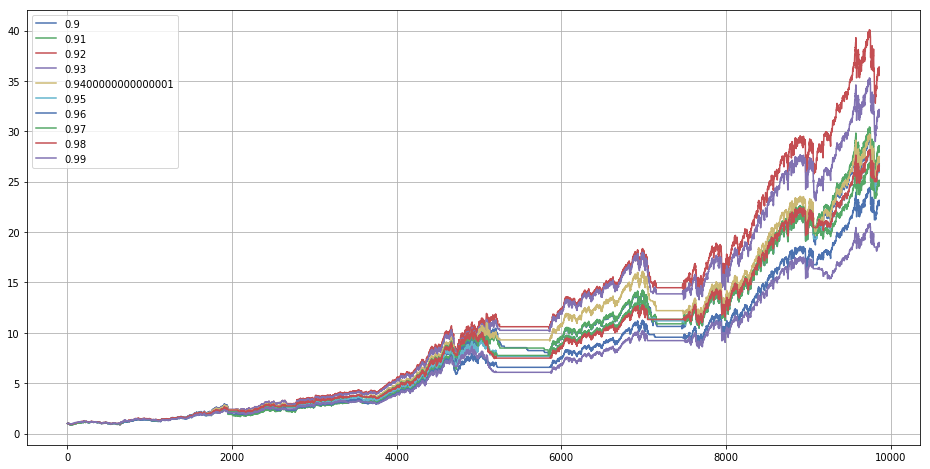

In [22]:
performance = {}

for x in np.linspace(.9,.99,10):
    y = ((df['y'] > df['yhat_lower']*x).shift(1)* (df['Percent Change']) + 1).cumprod()
    performance[x] = y
    
best_yhat = pd.DataFrame(performance).max().idxmax()
pd.DataFrame(performance).plot(figsize=(16,8), grid=True);
f'Best Yhat = {best_yhat:,.2f}'

Above we loop through various percents of the thresh to find the optimal thresh.  It appears the best threshhold is 92% of our current yhat_lower.

In [23]:
df['Optimized Prophet Thresh']  = ((df['y'] > df['yhat_lower'] * best_yhat).shift(1) * 
                                   (df['Percent Change']) + 1).cumprod()

Hold = 24,396
Prophet = 13,366
Prophet Thresh = 17,087
Seasonality = 30,861
Optimized Prophet Thresh = 36,375


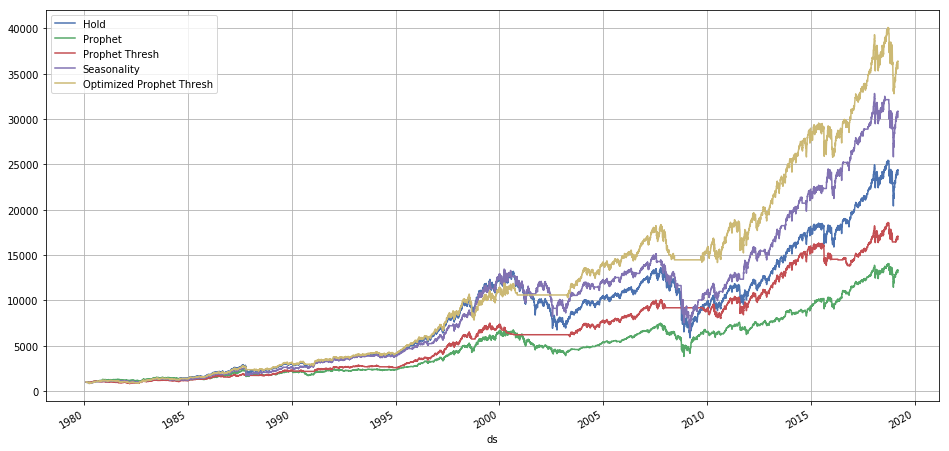

In [24]:
(df.dropna().set_index('ds')[['Hold', 'Prophet', 'Prophet Thresh',
                              'Seasonality', 'Optimized Prophet Thresh']] * 1000).plot(figsize=(16,8), grid=True)

print(f"Hold = {df['Hold'].iloc[-1]*1000:,.0f}")
print(f"Prophet = {df['Prophet'].iloc[-1]*1000:,.0f}")
print(f"Prophet Thresh = {df['Prophet Thresh'].iloc[-1]*1000:,.0f}")
print(f"Seasonality = {df['Seasonality'].iloc[-1]*1000:,.0f}")
print(f"Optimized Prophet Thresh = {df['Optimized Prophet Thresh'].iloc[-1]*1000:,.0f}")

Above we see our new `Optimized Prophet Thresh` is the best trading stratege.  **Unfortunately**, both the `Seasonaity` and `Optimized Prophet Thresh` are both cheating since they are using data from the future that wouldn't be available at the time of our trade.  We are going to need to create an Optimized Thresh for each curent point in time of our Forecast.

In [25]:
fcst_thresh = {}

for num, index in enumerate(df['month/year_index'].unique()):

    temp_df = df.set_index('ds')[
         df[df['month/year_index'] == df['month/year_index'].unique()[0]]['ds'].min():\
         df[df['month/year_index'] == index]['ds'].max()]

    performance = {}
    
    for thresh in np.linspace(0, .99, 100):
        percent =  ((temp_df['y'] > temp_df['yhat_lower'] * thresh).shift(1)* (temp_df['Percent Change']) + 1).cumprod()
        performance[thresh] = percent
    
    best_thresh = pd.DataFrame(performance).max().idxmax()
    
    if num == len(df['month/year_index'].unique())-1:
        pass
    else:
        fcst_thresh[df['month/year_index'].unique()[num+1]] = best_thresh


In [26]:
fcst_thresh = pd.DataFrame([fcst_thresh]).T.reset_index().rename(columns={'index':'month/year_index', 0:'Fcst Thresh'})

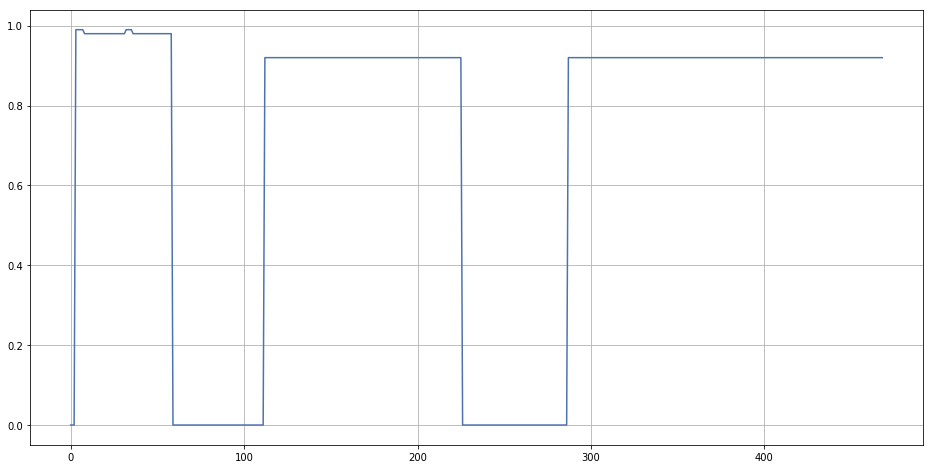

In [27]:
fcst_thresh['Fcst Thresh'].plot(figsize=(16,8), grid=True);

Above, like how we created our monthly forecast, we loop through the data and find the optimal thresh percent period to date for that current point in time.  As you can see the % of the current thresh jumps around as we get further in to the periods (1/1/1980 - 3/18/2019).  

In [28]:
df['yhat_optimized'] = pd.merge(df, fcst_thresh, 
                                on='month/year_index', 
                                how='left')['Fcst Thresh'].shift(1) * df['yhat_lower']

In [29]:
df['Prophet Fcst Thresh']  = ((df['y'] > df['yhat_optimized']).shift(1)* (df['Percent Change']) + 1).cumprod()

Hold = 24,396
Prophet = 13,366
Prophet Thresh = 17,087
Prophet Fcst Thresh = 20,620


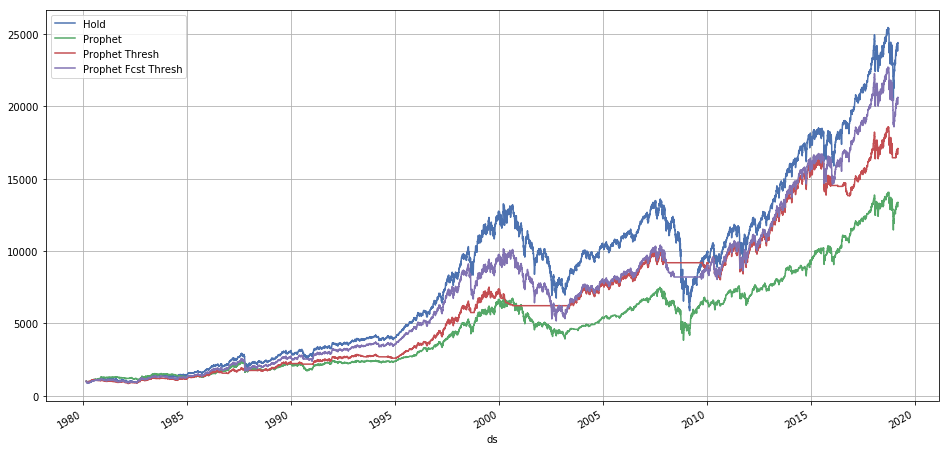

In [30]:
(df.dropna().set_index('ds')[['Hold', 'Prophet', 'Prophet Thresh',
                              'Prophet Fcst Thresh']] * 1000).plot(figsize=(16,8), grid=True)

print(f"Hold = {df['Hold'].iloc[-1]*1000:,.0f}")
print(f"Prophet = {df['Prophet'].iloc[-1]*1000:,.0f}")
print(f"Prophet Thresh = {df['Prophet Thresh'].iloc[-1]*1000:,.0f}")
# print(f"Seasonality = {df['Seasonality'].iloc[-1]*1000:,.0f}")
print(f"Prophet Fcst Thresh = {df['Prophet Fcst Thresh'].iloc[-1]*1000:,.0f}")

As we did before we create the new trading strategy and graph it.  Unfortunately are results have gotten worse but we did do better then our initial `Prophet Thresh`.  Instead of calculating the thresh using the full period to date let's try various rolling windows of time like you would see with a moving average(30, 60, 90, etc.).

In [31]:
rolling_thresh = {}

for num, index in enumerate(df['month/year_index'].unique()):
  
    rolling_performance = {}
    
    for roll in range(10, 400, 10):
            
        temp_df = df.set_index('ds')[
             df[df['month/year_index'] == index]['ds'].min() - pd.DateOffset(months=roll):\
             df[df['month/year_index'] == index]['ds'].max()]

        performance = {}
        
        for thresh in np.linspace(.0,.99, 100):
            percent =  ((temp_df['y'] > temp_df['yhat_lower'] * thresh).shift(1)* (temp_df['Percent Change']) + 1).cumprod()
            performance[thresh] = percent

        per_df =  pd.DataFrame(performance)
        best_thresh = per_df.iloc[[-1]].max().idxmax()
        percents = per_df[best_thresh]
        
        rolling_performance[best_thresh] = percents
    
    per_df =  pd.DataFrame(rolling_performance)
    best_rolling_thresh = per_df.iloc[[-1]].max().idxmax()
    
    if num == len(df['month/year_index'].unique())-1:
        pass
    else:
        rolling_thresh[df['month/year_index'].unique()[num+1]] = best_rolling_thresh

In [32]:
rolling_thresh = pd.DataFrame([rolling_thresh]).T.reset_index().rename(columns={'index':'month/year_index', 0:'Fcst Thresh'})

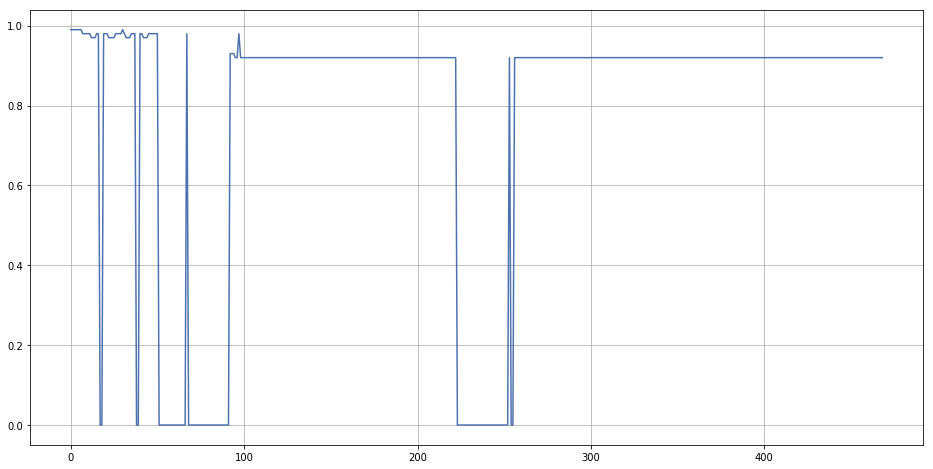

In [33]:
rolling_thresh['Fcst Thresh'].plot(figsize=(16,8), grid=True);

Above is very simliar to before but now we are trying out various moving windows along with various threshold percents.  This is getting quite complex.  No wonder Quants make so much money.  As you can see from above the thresh percents change over time.  Now let's see how we did.

In [34]:
df['yhat_optimized'] = pd.merge(df, rolling_thresh, 
                                on='month/year_index', 
                                how='left')['Fcst Thresh'].fillna(1).shift(1) * df['yhat_lower']

In [35]:
df['Prophet Rolling Thresh']  = ((df['y'] > df['yhat_optimized']).shift(1)* (df['Percent Change']) + 1).cumprod()

Hold = 24,396
Prophet = 13,366
Prophet Thresh = 17,087
Prophet Fcst Thresh = 20,620
Prophet Rolling Thresh = 23,621


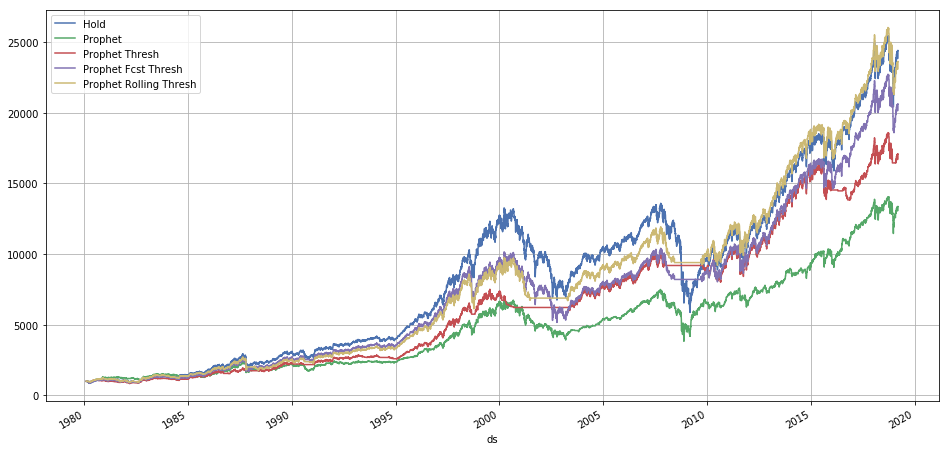

In [36]:
(df.dropna().set_index('ds')[['Hold', 'Prophet', 'Prophet Thresh',
                              'Prophet Fcst Thresh', 'Prophet Rolling Thresh']] * 1000).plot(figsize=(16,8), grid=True)

print(f"Hold = {df['Hold'].iloc[-1]*1000:,.0f}")
print(f"Prophet = {df['Prophet'].iloc[-1]*1000:,.0f}")
print(f"Prophet Thresh = {df['Prophet Thresh'].iloc[-1]*1000:,.0f}")
# print(f"Seasonality = {df['Seasonality'].iloc[-1]*1000:,.0f}")
print(f"Prophet Fcst Thresh = {df['Prophet Fcst Thresh'].iloc[-1]*1000:,.0f}")
print(f"Prophet Rolling Thresh = {df['Prophet Rolling Thresh'].iloc[-1]*1000:,.0f}")

As you can see our new `Porphet Rolling Thresh` did pretty well but still did't beat out the simpliest `Hold` strategy.  Perhaps the saying "Time in the Market is better then Timing the Market" has some truth to it.

In [37]:
df['Time Traveler'] = ((df['y'].shift(-1) > df['yhat']).shift(1) * (df['Percent Change']) + 1).cumprod()

Hold = 24,396
Prophet = 13,366
Prophet Thresh = 17,087
Prophet Fcst Thresh = 20,620
Prophet Rolling Thresh = 23,621
Time Traveler = 288,513


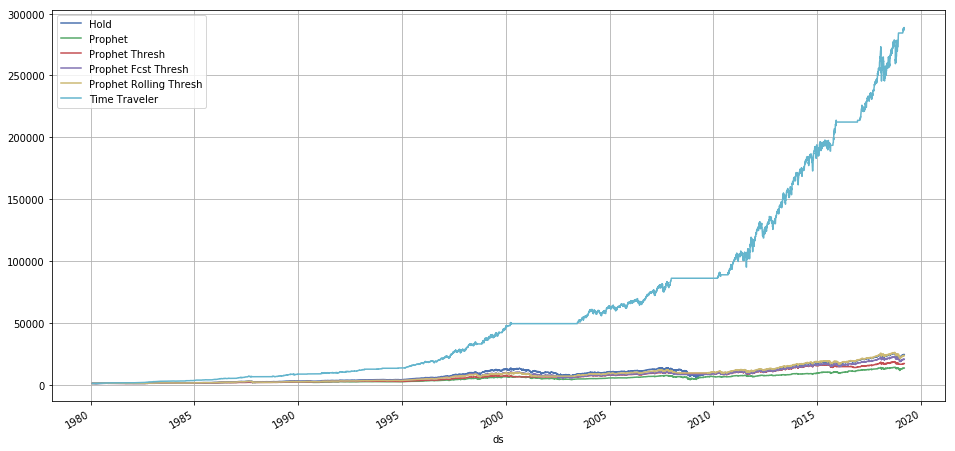

In [38]:
(df.dropna().set_index('ds')[['Hold', 'Prophet', 'Prophet Thresh',
                              'Prophet Fcst Thresh', 'Prophet Rolling Thresh',
                              'Time Traveler']] * 1000).plot(figsize=(16,8), grid=True)

print(f"Hold = {df['Hold'].iloc[-1]*1000:,.0f}")
print(f"Prophet = {df['Prophet'].iloc[-1]*1000:,.0f}")
print(f"Prophet Thresh = {df['Prophet Thresh'].iloc[-1]*1000:,.0f}")
# print(f"Seasonality = {df['Seasonality'].iloc[-1]*1000:,.0f}")
print(f"Prophet Fcst Thresh = {df['Prophet Fcst Thresh'].iloc[-1]*1000:,.0f}")
print(f"Prophet Rolling Thresh = {df['Prophet Rolling Thresh'].iloc[-1]*1000:,.0f}")
print(f"Time Traveler = {df['Time Traveler'].iloc[-1]*1000:,.0f}")

Above I implemented my `Time Traveler` strategy. This of course would be a perfect trading strategy as I know in advance when the market moves up or down.  As you can the most you could make is $288,513 from $1,000. 

## Summary

Time Series Forecasting can be quite complex however Prophet makes it very easy to create robust forecasts with little effort.  While it didn't make us rich with its stock market predictions it is still very useful and can be implemented quickly to solve many use cases in various areas.